# Тестирование гипотез в Python

In [1]:
import pandas as pd
import scipy.stats as scs
import statsmodels.stats.diagnostic as sm
import seaborn as sns
import pingouin as pg
df = pd.read_csv('sleep75.csv')
df.shape # Размер датасета

(706, 34)

Основные переменные в датафрейме `df`
- `sleep`: продолжительность сна (мин/нед)
- `totwrk`: рабочее время (мин/нед)
- `age`: возраст (в годах)
- `educ`: уровень образрвания в годах
- `male`: гендерный фактор (бинарная, =1 для мужчин)
- `south`: географический фактор (бинарная, =1 если живёт на юге)

In [2]:
df.shape[0] # Число наблюдений

706

## Одновыборочный t-тест
Для переменной `sleep` будем тестировать гипотезу $H_0:\mu=3200$
Уровень значимости выберем 5%

In [5]:
# Первый способ с использованием библиотеки scipy.stats
t_stat, p_val=scs.ttest_1samp(a=df['sleep'], popmean=3200)
t_stat, p_val

(np.float64(3.9672744144153147), np.float64(8.013385140555246e-05))

5%-критическое значение $t$-распределения со степенями свободы $n-1=705$

In [6]:
scs.t.ppf( q=1-0.05/2, df=df['sleep'].shape[0]-1 )

np.float64(1.9633345943574534)

In [8]:
# Второй способ с использованием бибиотеки pengouin
pg.ttest(x=df['sleep'], y=3200)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.967274,705,two-sided,0.00008,"[3233.52, 3299.19]",0.14931,98.426,0.977352


**Вывод**: на выбранно уровне значимости тестируемая гипотеза отвергается ($|t|>t_{cr}$, p_val<5\%)

## Двухвыборочный t-тест
Разделим наблюдения по переменной `sleep` на две подвыборки относительно бинарной переменной `male`.
Будем тестировать гипотезу о равенстве средних в генеральной совокупности $H_0:\mu_{X}=\mu_{Y}$ при **допущении неравенства дисперсий**. Уровень значимости выберем 1%

In [9]:
# Первый способ с использованием библиотеки scipy.stats
X = df[ df['male']==1 ]['sleep']
Y = df[ df['male']==0 ]['sleep']
t_stat, p_val=scs.ttest_ind(a=X, b=Y, equal_var=False)
t_stat, p_val

(np.float64(-0.9474052094024158), np.float64(0.34378977584461323))

In [10]:
# Второй способ с использованием бибиотеки pengouin
pg.ttest(x=X,y=Y)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.947405,640.242596,two-sided,0.34379,"[-98.88, 34.52]",0.072407,0.132,0.158552


1%-критическое значение $t$-распределения со степенями свободы $$df=\frac{\left(s_X^2/n+s_Y^2/m\right)^2}{\frac{(s^2_X/n)^2}{n-1}+\frac{(s^2_Y/m)^2}{m-1}} $$

In [11]:
s_X=X.std()
s_Y=Y.std()
n=X.shape[0]
m=Y.shape[0]
# степени свободы
dof=((s_X**2)/n+(s_Y**2)/m)**2 /( ((s_X**2)/n)**2/(n-1)+((s_Y**2)/m)**2/(m-1) )
# критическое значение t-распределения
t_cr=scs.t.ppf( q=1-0.05/2, df=dof )
t_cr, dof

(np.float64(1.9636761492270411), 640.2425956081363)

## Значимость корреляции
Проверим значимость корреляции между переменными `sleep` и `totwrk`. Уровень значимости выберем 10%

In [12]:
# Первый способ с использованием библиотеки scipy.stats
t_stat, p_val=scs.pearsonr(x=df['sleep'], y=df['totwrk'])
t_stat, p_val

(np.float64(-0.32138353369305783), np.float64(1.994094951876018e-18))

In [13]:
# Второй способ с использованием бибиотеки pingouin
pg.corr(x=df['sleep'], y=df['totwrk'])

,n,r,CI95%,p-val,BF10,power
pearson,706,-0.321384,"[-0.39, -0.25]",1.994095e-18,1.961e+15,1.0


10%-критическое значение $t$-распределения со степенями свободы $n-2=704$

In [14]:
scs.t.ppf( q=1-0.10/2, df=df['sleep'].shape[0]-2 )

np.float64(1.6470209401133937)

**Вывод**: корреляция значима

Проверим значимость корреляции между переменными `age` и `totwrk`.

In [15]:
t_stat, p_val=scs.pearsonr(x=df['age'], y=df['totwrk'])
t_stat, p_val

(np.float64(-0.04956989119946762), np.float64(0.18831515338531457))

In [16]:
# Второй способ с использованием бибиотеки pengouin
pg.corr(x=df['age'], y=df['totwrk'])

,n,r,CI95%,p-val,BF10,power
pearson,706,-0.04957,"[-0.12, 0.02]",0.188315,0.112,0.260364


**Вывод**: корреляция незначима (критическое значение тоже)

<Axes: >

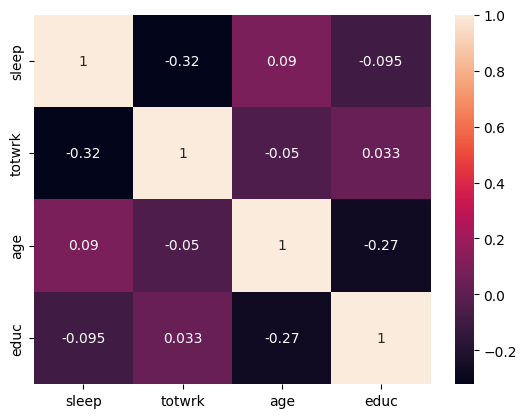

In [17]:
# Визц=уализация корреляционной матрицы
sns.heatmap(df[['sleep', 'totwrk', 'age', 'educ']].corr(), annot = True)

## Одновыборочный тест Колмогорова-Смирнова на сравнение с нормальным распределением
Для переменной `sleep`

In [18]:
sm.lilliefors(df['sleep'], dist='norm')

(np.float64(0.046880441069508394), np.float64(0.0015723943766754293))

5%-критическое значение $\lambda_{cr}=0.886$.
**Вывод**: гипотеза отвергается

<Axes: xlabel='sleep', ylabel='Proportion'>

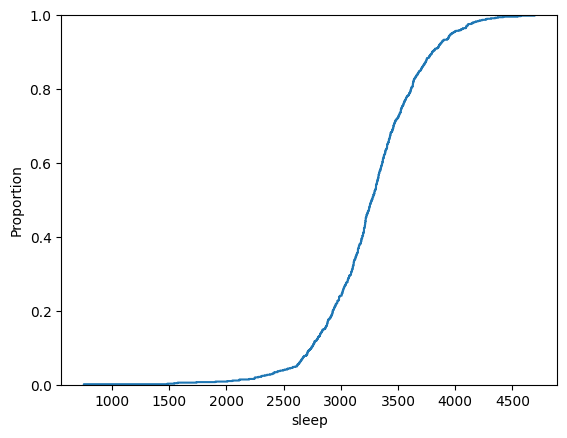

In [19]:
# Эмпирическая функция распределения для sleep
sns.ecdfplot(df, x='sleep')

## Двухвыборочный тест Колмогорова-Смирнова
Разделим наблюдения по переменной `sleep` на две подвыборки относительно бинарной переменной `male`. Потестируем гипотезу об одинаковой распределённости эти выборок

In [20]:
X = df[ df['male']==1 ]['sleep']
Y = df[ df['male']==0 ]['sleep']
stat, p_val=scs.ks_2samp(X,Y)
stat, p_val

(np.float64(0.07794117647058824), np.float64(0.22739744706319376))

5%-критическое значени $\lambda_{cr}=1.36$. 
**Вывод**: тестируемая гипоза не отвергается

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='sleep', ylabel='Proportion'>

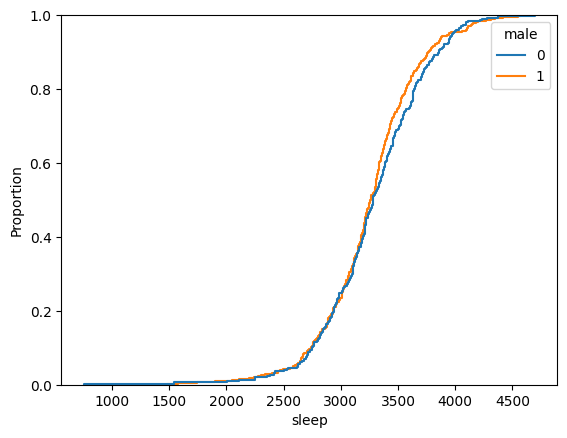

In [21]:
sns.ecdfplot(df, x='sleep', hue='male')

Разделим наблюдения по переменной `totwrk` на две подвыборки относительно бинарной переменной `south`. Потестируем гипотезу об одинаковой распределённости эти выборок

In [22]:
X = df[ df['south']==1 ]['totwrk']
Y = df[ df['south']==0 ]['totwrk']
stat, p_val=scs.ks_2samp(X,Y)
stat, p_val

(np.float64(0.1063034188034188), np.float64(0.16754841740423074))

Критическое значение такое же. Гипотеза не отвергается


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='totwrk', ylabel='Proportion'>

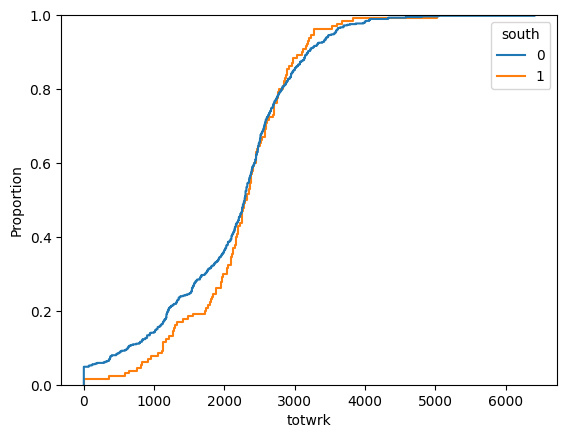

In [23]:
# Эмпириеские функции распределения для totwrk с разделением по бинраной переменной south
sns.ecdfplot(df, x='totwrk', hue='south')